In [1]:
#import libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from xgboost import plot_importance
from xgboost import plot_tree
import graphviz
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import itertools

In [41]:
data = pd.read_csv("PELNE DANE.csv", delimiter=";", decimal=",")

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 26 columns):
Gatunek    3029 non-null object
KOL        3029 non-null object
APZ        152 non-null float64
APW        147 non-null float64
D1         451 non-null float64
D2         452 non-null float64
PS         439 non-null float64
R          2519 non-null float64
SC         424 non-null float64
PL         2570 non-null float64
PYL        2564 non-null float64
K-J        2725 non-null float64
PYLZN      2212 non-null float64
PYLPL      2528 non-null float64
ZN         453 non-null float64
SZY        339 non-null float64
NB         249 non-null float64
KAT        278 non-null float64
V          505 non-null float64
KON        572 non-null float64
MASA       477 non-null float64
POW        948 non-null float64
NAS        793 non-null float64
WYS        793 non-null float64
SZER       793 non-null float64
SZEW       606 non-null float64
dtypes: float64(24), object(2)
memory usage: 615.3+ KB


In [43]:
#retruns pollinator
def pollinator(name):
    if((name == 'F. eduardii') | (name == 'F. imperialis')):
        return "PAS"
    elif ((name == "F. recurva") | (name == "F. gentneri")):
        return "HUM"
    else:
        return "INS"

In [44]:
data['Pollinator'] = data['Gatunek'].apply(pollinator)

In [6]:
col = {'INS':'#FFE125', 'PAS':'#007800', 'FLY':"#e5247e", 'HUM':'#bf0000'}

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/home/kodolamacz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


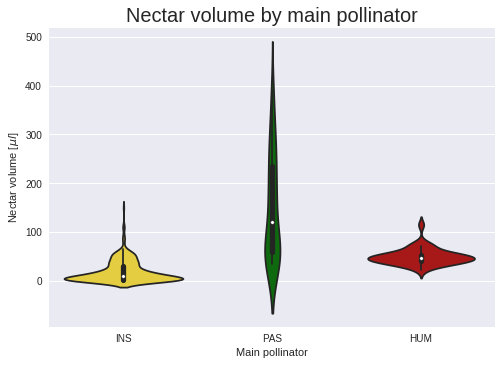

In [7]:
sns.violinplot(x="Pollinator", y ="V", data=data, palette=col)
sns.set_style("white")
plt.title("Nectar volume by main pollinator", fontsize=20)
plt.ylabel(r'Nectar volume [$\mu l$]')
plt.xlabel("Main pollinator")
plt.savefig('Vol.jpg', bbox_inches="tight", dpi=1000)
plt.show()

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/home/kodolamacz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


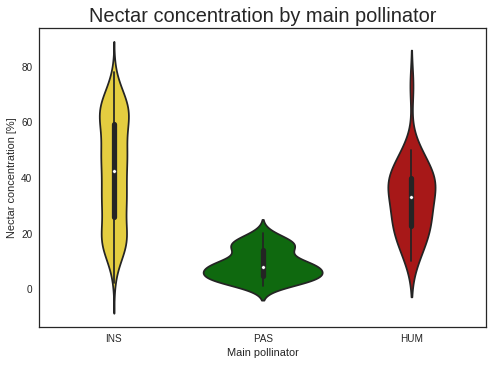

In [8]:
sns.violinplot(x="Pollinator", y ="KON", data=data, palette=col)
sns.set_style("white")
plt.title("Nectar concentration by main pollinator", fontsize=20)
plt.ylabel(r'Nectar concentration [%]')
plt.xlabel("Main pollinator")
plt.savefig('kon.jpg', bbox_inches="tight", dpi=1000)
plt.show()

In [36]:
data.head()

,Gatunek,KOL,APZ,APW,D1,D2,PS,R,SC,PL,...,V,KON,MASA,POW,NAS,WYS,SZER,SZEW,Pollinator,stosunek
0,F. acmopetala,1,9.0,4.0,40.95,42.18,27.58,0.813809,30.71,33.89,...,35.0,16.50,0.003784,14.0,4.0,10.5,3.5,2.0,INS,0.844792
1,F. acmopetala,1,17.0,2.0,44.74,39.21,26.61,0.785187,32.68,33.89,...,24.0,35.25,0.003021,15.0,5.0,6.5,3.5,1.8,INS,0.870168
2,F. acmopetala,1,9.0,0.0,44.93,44.77,28.71,0.916667,46.90,31.32,...,NaN,NaN,NaN,25.8,5.0,8.0,3.0,1.2,INS,0.913474
3,F. acmopetala,1,9.0,NaN,40.39,40.62,24.05,0.742513,48.83,32.39,...,NaN,NaN,NaN,31.4,2.5,9.0,3.0,1.3,INS,0.859833
4,F. acmopetala,1,9.0,NaN,42.61,42.85,26.79,0.750000,56.60,35.72,...,40.0,21.00,0.003113,19.1,4.0,8.5,3.0,1.5,INS,0.779675


In [56]:
data.Gatunek.describe()

count              3029
unique               73
top       F. imperialis
freq                352
Name: Gatunek, dtype: object

In [52]:
data.Gatunek.value_counts()

F. imperialis         352
F. persica            259
F. sthenanthera       222
F. pallidiflora       184
F. raddeana           182
F. michailovski       150
F. sewerzowii         146
F. uva vulpis         140
F. acmopetala         132
F. gentneri           104
F. minuta              84
F. ruthenica           76
F. carica              72
F. bucharica           66
F. amana               50
F. olivieri            47
F. eduardii            47
F. camtschatcensis     45
F. assyriaca           44
F. recurva             36
F. olgae               36
F. davisi              30
F. verticilliata       30
F. gussichiae          26
F. sibthorpiana        25
F. montana             24
F. hermonis            23
F. mutabilis           18
F. caucasica           18
F. whitallii           18
                     ... 
F. sororum             10
F. obliqua              9
F. grandiflora          8
F. involucrata          8
F. gibbosa              7
F. latakesis            7
F. elwesii              7
F. drenovski

In [57]:
data[['KON', 'V', 'PL', "Pollinator"]].groupby(['Pollinator']).agg(['count']).reset_index()

,Pollinator,KON,V,PL
,,count,count,count
0,HUM,35,36,90
1,INS,493,425,2114
2,PAS,44,44,366


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 27 columns):
Gatunek       3029 non-null object
KOL           3029 non-null object
APZ           152 non-null float64
APW           147 non-null float64
D1            451 non-null float64
D2            452 non-null float64
PS            439 non-null float64
R             2519 non-null float64
SC            424 non-null float64
PL            2570 non-null float64
PYL           2564 non-null float64
K-J           2725 non-null float64
PYLZN         2212 non-null float64
PYLPL         2528 non-null float64
ZN            453 non-null float64
SZY           339 non-null float64
NB            249 non-null float64
KAT           278 non-null float64
V             505 non-null float64
KON           572 non-null float64
MASA          477 non-null float64
POW           948 non-null float64
NAS           793 non-null float64
WYS           793 non-null float64
SZER          793 non-null float64
SZEW        

In [55]:
amino = pd.read_csv("aminokwasy.csv")

In [10]:
amino["Total"] = amino.iloc[:,3:33].sum(axis = 1)

In [11]:
amino["Pollinator"] = amino["Gatunek"].apply(pollinator)

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


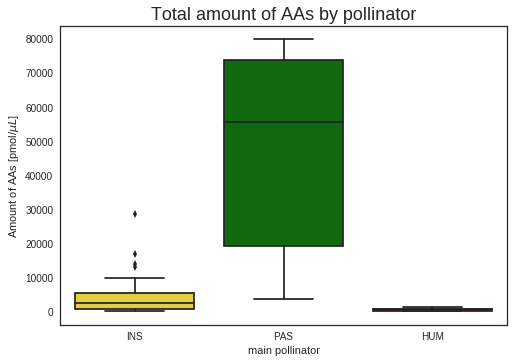

In [12]:
sns.boxplot(data=amino, x='Pollinator', y='Total', 
           palette=col)
plt.xlabel("main pollinator")
plt.ylabel("Amount of AAs [pmol/$\mu L$]")
plt.title("Total amount of AAs by pollinator", fontsize=18)
plt.savefig('aa.jpg', bbox_inches="tight", dpi = 1000)
plt.show()

In [13]:
df = data.groupby(['Gatunek']).agg({'V': 'mean', 'KON': 'mean', 
                                    'MASA':'mean'}).reset_index()

In [14]:
df.head()

,Gatunek,V,KON,MASA
0,F. acmopetala,40.303615,36.1800,0.013834
1,F. affinis,15.400000,13.0000,NaN
2,F. amabilis,NaN,NaN,NaN
3,F. amana,13.350000,47.8125,0.004443
4,F. argolica,NaN,NaN,NaN


In [15]:
df['Pollinator'] = df['Gatunek'].apply(pollinator)

In [16]:
df.dropna(inplace=True)

In [17]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets 
import numpy as np
from scipy import special

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



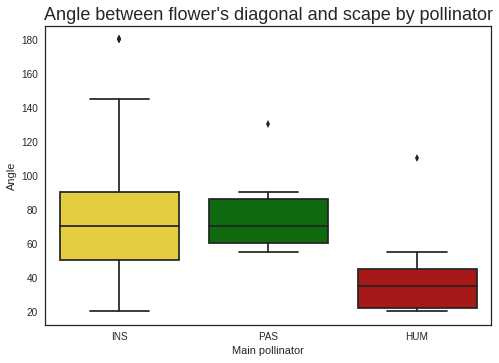

In [18]:
sns.boxplot(data=data, x='Pollinator', y='KAT', 
           palette=col)
plt.xlabel("Main pollinator")
plt.ylabel("Angle")
plt.title("Angle between flower's diagonal and scape by pollinator", fontsize=18)
plt.savefig('angle.jpg', bbox_inches="tight", dpi = 1000)
plt.show()

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



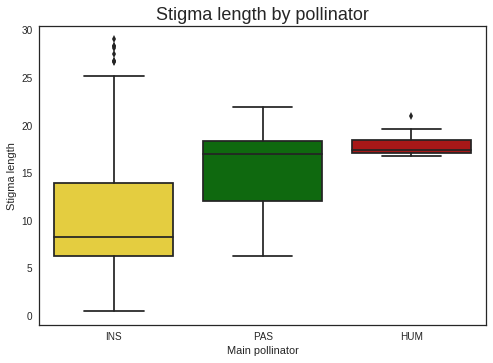

In [19]:
sns.boxplot(data=data, x='Pollinator', y='SZY', 
           palette=col)
plt.xlabel("Main pollinator")
plt.ylabel("Stigma length")
plt.title("Stigma length by pollinator", fontsize=18)
plt.savefig('stigma.jpg', bbox_inches="tight", dpi = 1000)
plt.show()

In [20]:
data["stosunek"] = data["PYL"] / data["PL"]

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



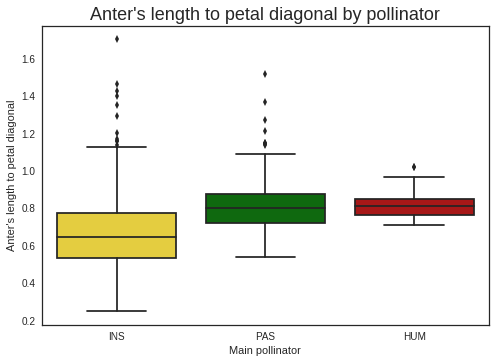

In [21]:
sns.boxplot(data=data, x='Pollinator', y='stosunek', 
           palette=col)
plt.xlabel("Main pollinator")
plt.ylabel("Anter's length to petal diagonal")
plt.title("Anter's length to petal diagonal by pollinator", fontsize=18)
plt.savefig('stosunek.jpg', bbox_inches="tight", dpi = 1000)
plt.show()

In [22]:
data.Pollinator.unique()

array(['INS', 'PAS', 'HUM'], dtype=object)

In [23]:
ins_st = data.stosunek[data.Pollinator == "INS"]

In [24]:
pas_st = data.stosunek[data.Pollinator == "PAS"]
hum_st = data.stosunek[data.Pollinator == "HUM"]

In [25]:
pas_st.dropna(inplace=True)

In [26]:
hum_st.dropna(inplace=True)
ins_st.dropna(inplace=True)

In [27]:
from scipy import stats

In [28]:
stats.kruskal(ins_st, pas_st, hum_st)

KruskalResult(statistic=298.52334427697025, pvalue=1.5013412963642521e-65)

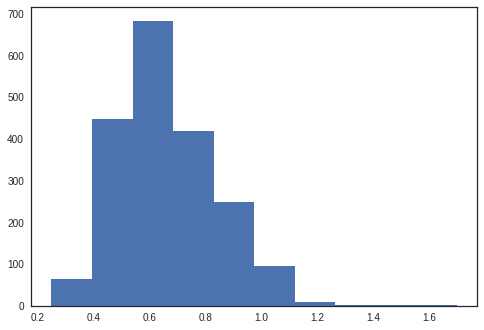

In [29]:
plt.hist(ins_st)
plt.show()

### Testing normality of PL/PYL

In [30]:
from statsmodels.stats.diagnostic import lillifors

pVals = pd.Series()
# The scipy normaltest is based on D-Agostino and Pearsons test that
# combines skew and kurtosis to produce an omnibus test of normality.
_, pVals['Omnibus']    = stats.normaltest(ins_st)

# Shapiro-Wilk test
_, pVals['Shapiro-Wilk']    = stats.shapiro(ins_st)

# Or you can check for normality with Lilliefors-test
_, pVals['Lilliefors']    = lillifors(ins_st)

# Alternatively with original Kolmogorov-Smirnov test
_, pVals['Kolmogorov-Smirnov']    = stats.kstest((ins_st-np.mean(ins_st))/np.std(ins_st,ddof=1), 'norm')

print('p-values for all {0} data points: ----------------'.format(len(ins_st)))
print(pVals)

if pVals['Omnibus'] > 0.05:
    print('Data are normally distributed')

ImportError: cannot import name 'TimeSeries'

In [ ]:
#fewData = fewData_t
pVals = pd.Series()
#pFewVals = pd.Series()
# The scipy normaltest is based on D-Agostino and Pearsons test that
# combines skew and kurtosis to produce an omnibus test of normality.
_, pVals['Omnibus']    = stats.normaltest(hum_st)

# Shapiro-Wilk test
_, pVals['Shapiro-Wilk']    = stats.shapiro(hum_st)

# Or you can check for normality with Lilliefors-test
_, pVals['Lilliefors']    = lillifors(hum_st)

# Alternatively with original Kolmogorov-Smirnov test
_, pVals['Kolmogorov-Smirnov']    = stats.kstest((hum_st-np.mean(hum_st))/np.std(hum_st,ddof=1), 'norm')

print('p-values for all {0} data points: ----------------'.format(len(hum_st)))
print(pVals)

if pVals['Omnibus'] > 0.05:
    print('Data are normally distributed')

In [ ]:
pVals = pd.Series()

_, pVals['Omnibus']    = stats.normaltest(pas_st)

# Shapiro-Wilk test
_, pVals['Shapiro-Wilk']    = stats.shapiro(pas_st)

# Or you can check for normality with Lilliefors-test
_, pVals['Lilliefors']    = lillifors(pas_st)

# Alternatively with original Kolmogorov-Smirnov test
_, pVals['Kolmogorov-Smirnov']    = stats.kstest((pas_st-np.mean(pas_st))/np.std(pas_st,ddof=1), 'norm')

print('p-values for all {0} data points: ----------------'.format(len(pas_st)))
print(pVals)

if pVals['Omnibus'] > 0.05:
    print('Data are normally distributed')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from statsmodels.stats.libqsturng import psturng

In [ ]:
# First, check if the variances are equal, with the "Levene"-test
(W,p) = stats.levene(ins_st, pas_st, hum_st)
if p<0.05:
    print(('Warning: the p-value of the Levene test is <0.05: p={0}'.format(p)))

In [ ]:
f, p = stats.f_oneway(ins_st,
                      hum_st,
                      pas_st)
 
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

In [ ]:
?stats.f_oneway

In [ ]:
#removing na rows form original data
st = data[np.isfinite(data['stosunek'])]

In [ ]:
#Then, do the multiple testing
multiComp = MultiComparison(st['stosunek'], st['Pollinator'])

In [ ]:
print((multiComp.tukeyhsd().summary()))

In [ ]:
print(multiComp.kruskal().summary())

In [ ]:
import pandas as pd

In [ ]:
import scikit_posthocs as sp

In [ ]:
x = [ins_st, hum_st, pas_st]

In [ ]:
sp.posthoc_dunn(x)

In [ ]:
?sp.posthoc_dunn